In [1]:
import gym
import scipy.optimize
import roboschool
from agent_file import agent
import numpy as np
import random
from expert import *
import matplotlib.pyplot as plt
import time
import pandas as pd
import seaborn as sns
from gym import spaces
plt.style.use('seaborn-white')
sns.set(context = "paper", font = "monospace")

In [2]:
class action_space(object):
    def __init__(self, env):
        self.env = env
        self.high = np.array([ 1,  1,  1,  1,  1])
        self.low = -np.array([ 1,  1,  1,  1,  1])
        self.shape = env.observation_space.shape
    
    def sample(self):
    
        return self.env.observation_space.sample()
        
        
class adversial_env(object):
    def __init__(self):
        # parameter
        self.env = gym.make("RoboschoolInvertedPendulum-v1")
        self.env.seed(0)
        self.ratio = 0.7
        self.threshold = np.array([ 0.14244403,  0.07706523,  0.00016789,  0.00789366,  0.02395424])
        self.max_turn = 1000
        self.combine_ratio = 0.05
        
        self.action_space = spaces.Box(low=-1, high=1, shape=(self.env.observation_space.shape[0],))
        self.observation_space = self.env.observation_space
        self.agent = SmallReactivePolicy(self.env.observation_space, self.env.action_space) # declare sample trained agent
        self.obsr = 0
        self.epi_num = 0
        self.total_score = 0
        self.first = True
        self.run_avg = 0
        self.rvg_list = []
        self.score_list = []
        self.epi_list = []
        self.env.metadata
    
    # define reward function
    def reward(self, st):
        return np.abs(st[3])+0.2*np.abs(st[1])-0.08#
    
    def step(self, a):
        self.epi_num = self.epi_num + 1
        
        obs = np.clip(a,-1,1)*self.threshold*self.ratio + self.obsr
        ac = self.agent.act(obs)
        self.obsr, r, done, _ = self.env.step(ac)
        #print( np.clip(a,-1,1),np.clip(a,-1,1)*self.ratio)
        
        if self.epi_num >= self.max_turn:
            done = True
        
        if self.first and done: ###################################
            self.first = False
            self.run_avg = self.total_score
            self.score_list = [self.total_score]
            self.epi_list = [self.epi_num]
            print(self.run_avg, self.score_list, self.epi_list)
            
        
        final_r = self.reward(self.obsr)
        if done and self.epi_num < self.max_turn:
            final_r = 15 # terminal cost 
        
        self.total_score += final_r
        return self.obsr, final_r, done, 0
        
        
    def seed(self, a):
        pass
    
    def reset(self):
        self.obsr = self.env.reset()
        #print(self.total_score)
        self.run_avg = (self.combine_ratio*self.total_score) + (1-self.combine_ratio)*self.run_avg
        #print(self.run_avg)
        #print(self.epi_num)
        
        if not self.first: #########################################
            self.rvg_list.append(self.run_avg)
            self.score_list.append(self.total_score)
            self.epi_list.append(self.epi_num)
        
        self.epi_num = 0
        self.total_score = 0
        return self.obsr
    
    def result_plot(self):
        fon_size = 19
        fig=plt.figure(figsize=(18, 4), dpi= 80, facecolor='w', edgecolor='k')
        plt.subplot(1,2,1)
        plt.plot(self.score_list[0:])
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('cumulative reward',fontsize=fon_size)
        #plt.subplot(1,3,2)
        #plt.plot(self.rvg_list[0:])
        #plt.xlabel('episodes')
        #plt.ylabel('running average reward')
        plt.subplot(1,2,2)
        plt.plot(self.epi_list)
        plt.xlabel('episodes',fontsize=fon_size)
        plt.ylabel('number of time steps',fontsize=fon_size)
        plt.show()

# define an observer (new agent)

In [3]:
class par(object):
    def __init__(self):
        self.gamma = 0.995
        self.env_name = "Reacher-v1"
        self.tau = 0.97
        self.l2_reg = 1e-3
        self.max_kl = 1e-2
        self.damping = 1e-1
        self.seed = 543
        self.batch_size = 15000
        self.max_epi = 6000
        self.log_interval = 1
        self.max_avg = 55
        
args = par()
env = adversial_env()
agn = agent(env, args)
#agn.load_model('agent_model/adversarial_agent2_distr')

[2018-02-13 04:00:09,044] Making new env: RoboschoolInvertedPendulum-v1


# Agent training

In [4]:
agn.learn()

-66.7758301304 [-66.775830130447346] [1000]
Episode 0	Last reward: -65.84032715041106	Average reward -65.78
('lagrange multiplier:', 0.3948367989834848, 'grad_norm:', 0.0447429257491688)
fval before -1.1627254714596802e-14
a/e/r 0.007447226637131457 0.007896735979669776 0.9430765643304291
fval after -0.007447226637143084
Episode 1	Last reward: -67.46247183809099	Average reward -65.42
('lagrange multiplier:', 0.24174362380016098, 'grad_norm:', 0.04041465505968838)
fval before 1.9306778398231473e-16
a/e/r 0.004597748231196259 0.004834872476003331 0.9509554293346973
fval after -0.004597748231196065
Episode 2	Last reward: -61.90977957733921	Average reward -64.91
('lagrange multiplier:', 0.26170742887669435, 'grad_norm:', 0.05146724482997622)
fval before -1.0430545316353346e-16
a/e/r 0.005435278279161589 0.005234148577533685 1.0384264410244686
fval after -0.005435278279161693
Episode 3	Last reward: -66.39681079441641	Average reward -65.33
('lagrange multiplier:', 0.3830977971097054, 'grad_n

('lagrange multiplier:', 0.2639587908997689, 'grad_norm:', 0.05384269494859671)
fval before -6.789013795582833e-17
a/e/r 0.005339912098727678 0.0052791758179930315 1.0115048793274963
fval after -0.005339912098727746
Episode 30	Last reward: -62.13263000255381	Average reward -64.45
('lagrange multiplier:', 0.22643780228672428, 'grad_norm:', 0.047897093486530005)
fval before -3.552713678800501e-18
a/e/r 0.004623574193476696 0.004528756045735414 1.020936907791836
fval after -0.004623574193476699
Episode 31	Last reward: -66.24749755800264	Average reward -65.88
('lagrange multiplier:', 0.25382956256110584, 'grad_norm:', 0.04542033652198247)
fval before 1.3311574065255628e-16
a/e/r 0.005422677233763328 0.005076591251222501 1.068172906860974
fval after -0.005422677233763195
Episode 32	Last reward: -66.56630549210573	Average reward -66.00
('lagrange multiplier:', 0.22445111218570088, 'grad_norm:', 0.03861508530776014)
fval before 2.370326157574709e-16
a/e/r 0.004869840695307806 0.00448902224371

a/e/r 0.005879415019720777 0.005879828116872313 0.9999297433286611
fval after -0.005879415019720718
Episode 59	Last reward: -62.427236028662605	Average reward -63.98
('lagrange multiplier:', 0.18956518230643096, 'grad_norm:', 0.04116040004619397)
fval before 1.9539925233402754e-17
a/e/r 0.0040042180100392415 0.003791303646123374 1.0561586155552518
fval after -0.0040042180100392216
Episode 60	Last reward: -65.42441494780984	Average reward -64.94
('lagrange multiplier:', 0.3571599511039109, 'grad_norm:', 0.0885682021819951)
fval before -2.653433028854124e-17
a/e/r 0.007388038618245588 0.007143199022103149 1.0342759029091635
fval after -0.007388038618245615
Episode 61	Last reward: -60.05515511953779	Average reward -63.70
('lagrange multiplier:', 0.19103248049432542, 'grad_norm:', 0.04725224507557274)
fval before -2.520761377411418e-16
a/e/r 0.003815087915704389 0.0038206496099107384 0.998544306656145
fval after -0.003815087915704641
Episode 62	Last reward: -65.12155063491211	Average rewar

Episode 88	Last reward: -60.97542270143387	Average reward -63.62
('lagrange multiplier:', 0.2302652159119488, 'grad_norm:', 0.04839457650577683)
fval before 5.1791904098763555e-17
a/e/r 0.00478483264392451 0.004605304318251104 1.0389829451578096
fval after -0.004784832643924458
Episode 89	Last reward: -61.548393684730314	Average reward -63.35
('lagrange multiplier:', 0.22411758878358395, 'grad_norm:', 0.05855704112007824)
fval before -9.831024883055761e-17
a/e/r 0.004430565113521588 0.004482351774252035 0.9884465424985328
fval after -0.004430565113521686
Episode 90	Last reward: -65.43669003568044	Average reward -63.51
('lagrange multiplier:', 0.2449213136302405, 'grad_norm:', 0.06491828469283761)
fval before 3.441691376337985e-17
a/e/r 0.0047594646805553505 0.00489842627260953 0.9716313803004019
fval after -0.004759464680555316
Episode 91	Last reward: -64.62968593490969	Average reward -64.02
('lagrange multiplier:', 0.26825599686105484, 'grad_norm:', 0.0677575136219874)
fval before 6.1

('lagrange multiplier:', 0.2675401905425219, 'grad_norm:', 0.05757538337156878)
fval before -1.6775469902086114e-16
a/e/r 0.0053136877314758045 0.005350803810781048 0.9930634572640358
fval after -0.005313687731475972
Episode 118	Last reward: -57.06605749296878	Average reward -61.37
('lagrange multiplier:', 0.27988702993485276, 'grad_norm:', 0.0674740030827508)
fval before -4.0256686872908175e-16
a/e/r 0.005937713702843827 0.005597740598873361 1.0607339868587142
fval after -0.00593771370284423
Episode 119	Last reward: -63.224519731482374	Average reward -61.06
('lagrange multiplier:', 0.18552680841178984, 'grad_norm:', 0.03500529665505947)
fval before 9.559020242022598e-17
a/e/r 0.0035626820163831303 0.0037105361682334076 0.9601528875756328
fval after -0.003562682016383035
Episode 120	Last reward: -63.317327185851816	Average reward -62.18
('lagrange multiplier:', 0.21597005208401615, 'grad_norm:', 0.04561936423634999)
fval before 4.296563105299356e-17
a/e/r 0.004213212297674198 0.0043194

a/e/r 0.0056433538721775926 0.005375403711324616 1.049847448720637
fval after -0.005643353872177622
Episode 147	Last reward: -62.22388497860902	Average reward -60.77
('lagrange multiplier:', 0.21896350634656947, 'grad_norm:', 0.04327919819921061)
fval before -2.1649348980190553e-18
a/e/r 0.004703857703116224 0.0043792701269061655 1.074119103595779
fval after -0.0047038577031162255
Episode 148	Last reward: -63.05579399566469	Average reward -61.93
('lagrange multiplier:', 0.21235237626157577, 'grad_norm:', 0.040019289460899506)
fval before -7.699396675775461e-17
a/e/r 0.004445245266909175 0.004247047525236135 1.0466671824356426
fval after -0.004445245266909252
Episode 149	Last reward: -58.60627318539537	Average reward -60.95
('lagrange multiplier:', 0.27770955638337497, 'grad_norm:', 0.057422520332348355)
fval before -1.2045919817182948e-17
a/e/r 0.005604453956762522 0.005554191127664222 1.0090495317757344
fval after -0.005604453956762534
Episode 150	Last reward: -63.84261097806509	Avera

Episode 176	Last reward: -44.34356126819247	Average reward -44.26
('lagrange multiplier:', 0.4345069870757078, 'grad_norm:', 0.10732042048232296)
fval before 4.085620730620576e-17
a/e/r 0.008860243526831835 0.008690139741517128 1.019574344069755
fval after -0.008860243526831794
Episode 177	Last reward: -42.35809478202746	Average reward -41.69
('lagrange multiplier:', 0.374456599381519, 'grad_norm:', 0.08208425700420205)
fval before 5.67323965583455e-17
a/e/r 0.007539611616806551 0.0074891319876313565 1.0067403845009761
fval after -0.007539611616806495
Episode 178	Last reward: -41.425146438136444	Average reward -41.60
('lagrange multiplier:', 0.410360026182643, 'grad_norm:', 0.08338196768866482)
fval before -2.5923707624997407e-17
a/e/r 0.008084242829021485 0.008207200523653764 0.9850183147983401
fval after -0.008084242829021511
Episode 179	Last reward: -39.60785974767724	Average reward -40.93
('lagrange multiplier:', 0.5368091751839034, 'grad_norm:', 0.09761577019289376)
fval before 8.

a/e/r 0.01327236450193102 0.01218216211781053 1.0894916988936303
fval after -0.013272364501930466
Episode 206	Last reward: 5.493268644597473	Average reward 7.12
('lagrange multiplier:', 0.6367589558539274, 'grad_norm:', 0.1976500956563788)
fval before 5.493962190190459e-16
a/e/r 0.013107464639431144 0.012735179117010394 1.0292328454119257
fval after -0.013107464639430595
Episode 207	Last reward: 9.141550491939572	Average reward 7.10
('lagrange multiplier:', 0.6609762753072769, 'grad_norm:', 0.15780482135620008)
fval before 2.701217749930267e-16
a/e/r 0.013837518849138503 0.013219525506144891 1.0467485268443522
fval after -0.013837518849138232
Episode 208	Last reward: 5.871606042216566	Average reward 7.08
('lagrange multiplier:', 0.5596404411175735, 'grad_norm:', 0.15110379013296457)
fval before -7.412894794507057e-16
a/e/r 0.011197371038799813 0.011192808822367797 1.0004076024619395
fval after -0.011197371038800554
Episode 209	Last reward: 7.264941842534093	Average reward 6.86
('lagran

KeyboardInterrupt: 

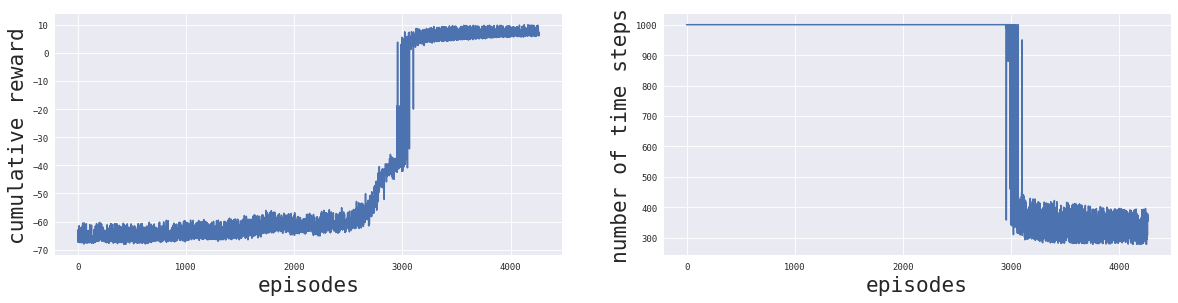

In [5]:
env.result_plot()

# Agent evaluation

In [6]:
env = adversial_env()
for i in range(1000):
    score = 0
    obs = env.reset()
    done = False
    itr = 0
    do = False
    time = 0
    while done == False:   
        a = agn.select_action_deterministic(obs)
        time +=1
        obs, r, done, _ = env.step(a)
        if done:
            do = True

        score += r

[2018-02-13 04:52:57,032] Making new env: RoboschoolInvertedPendulum-v1


-5.10413833911 [-5.1041383391101069] [280]


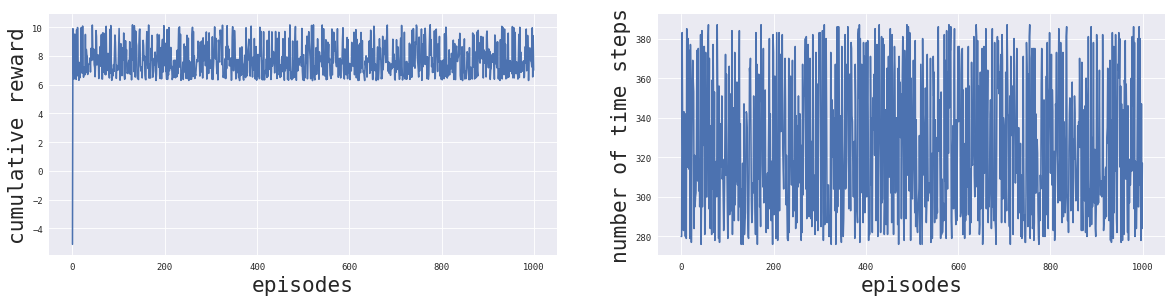

In [7]:
env.result_plot()

# Save model

In [8]:
agn.save_model('agent_model/adversarial_agent2_distr')

In [9]:
env.total_score

7.6529432730122622